In [1]:
# 代理人数量，20，25，30，35，40
# 投标人数量，3，6，9
# 投标分布(随机生成)最小值最大值； [10, 50]  
# 保存平台收益最大化和平台收支平衡的两个t值

In [2]:
from SC_VCG_multiprocess import *
from sklearn import linear_model
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,random

In [3]:
# 生成agents的bids和投标价值
def gen_value(agent_num,bid_num,self_bid_range,other_bid_range,platform_real_ratio = 1.0):
    self_bid_value = gen_data(agent_num,self_bid_range[0],self_bid_range[1],real_ratio=1)
    other_bid_value = [[] for i in range(agent_num)]
    for i in range(agent_num):
        other_bid_value[i] = gen_data(agent_num,other_bid_range[0],other_bid_range[1],real_ratio=1)
        other_bid_value[i][i] = 0

    xor_bid = [[0 for i in range(agent_num)] for j in range(agent_num)]
    for i in range(agent_num):
        xor_bid[i][i] = 0.000001
        bid_id = gen_objs(bid_num, i, agent_num)
        for j in range(len(bid_id)):
            #投标价格 = 对别人的估价 - 对自己的估价
            xor_bid[i][bid_id[j]] = other_bid_value[i][bid_id[j]] - self_bid_value[i]
    return xor_bid
    
#随机生成自我投标价值区间和对其他人物品的估值区间
def generate_bid_range(self_bid_range,other_bid_range):
    self_bid_range[1] -= np.random.randint(-10,10)
    other_bid_range[0] -= np.random.randint(-10,10)
    other_bid_range[1] += np.random.randint(-10,10)
    other_bid_range[0] = max(0,other_bid_range[0])
    return self_bid_range,other_bid_range

#根据训练集的单条数据提取得到需要训练的数据特征
def get_feature(single_data,agent_num,bid_num):
    remove_duplicate = []
    for col in single_data['bids']:
        lst = list(set(col))
        lst.remove(0)
        lst.remove(0.000001)
        remove_duplicate.append(lst)
    element_min,element_max = min(min(remove_duplicate)),max(max(remove_duplicate))
    max_t,balance_t,max_ps,balance_ps = 0,0,0,0
    for t in reversed(range(1,agent_num+1)):
        if single_data[t][1] >= 0:
            balance_t = t
            balance_ps = single_data[t][1]
            break
    for t in reversed(range(1,agent_num+1)):
        # print(single_data[t])
        if single_data[t][1] > max_ps:
            max_ps = single_data[t][1]
            max_t = t
    return element_min,element_max,max_t,balance_t,max_ps,balance_ps

#生成训练集
def generate_train_list(agent_range,bid_range,store_list,min_max_range = [0,20,10,50]):
    for store in store_list:     #修改生成训练集的文件夹
        for agent_num in range(agent_range[0],agent_range[1]):
            for bid_num in bid_range:
                self_bid_range,other_bid_range = generate_bid_range([min_max_range[0],min_max_range[1]],[min_max_range[2],min_max_range[3]])
                record_SC_VCG = []
                max_t = agent_num
                
                before = time.perf_counter()
                #每一轮次生成新的投标价值（V)
                bids = gen_value(agent_num,bid_num,self_bid_range,other_bid_range)   # agent_num*agent_num的矩阵
                SC_VCG = {}
                input_SCVCG = [(agent_num,bids,t) for t in reversed(range(1,max_t+1))]  #生成输入多进程池的元组
                #SC-VCG求解过程
                pool = mp.Pool(mp.cpu_count())
                SC_VCG_r = pool.map(cycle_compute_SC_VCG, input_SCVCG)                  #并发计算形成列表
                for r in SC_VCG_r:
                    SC_VCG.update(r)                                                    #将进程池返回的列表重新表达为字典
                record_SC_VCG.append(SC_VCG)
                pool.close()                                                            # close方法用于关闭进程池，即恢复到没有子进程的情况
                pool.join()
                
                after = time.perf_counter()
                print(f'total time:{after - before},agent_num:{agent_num},bid_num:{bid_num}')
                
                # 保存SC-VCG的对应信息；
                pickle_SC_VCG = {}
                pickle_SC_VCG['bids'] = bids
                for t in reversed(range(1,max_t+1)):
                    W_N,profits,RE,AP = 0,0,0,0
                    W_N = record_SC_VCG[0][t][0]                           #社会福利 social welfare
                    profits = record_SC_VCG[0][t][1]                       #平台盈余 platform surplus
                    RE = record_SC_VCG[0][t][4]/agent_num                  #实际交换数量占总体agent数量的百分比
                    AP = record_SC_VCG[0][t][6]/agent_num                  #agent's profits
                    pickle_SC_VCG[t] = [W_N,profits,RE,AP]
                #存储数据为pickle文件
                save_pkl_data_driven('SC-VCG',agent_num,bid_num,1,pickle_SC_VCG,store)

#生成测试集agents的bids和投标价值
def gen_test_value(agent_num,bid_num,min_bid_value,max_bid_value,platform_real_ratio = 1.0):
    xor_bid = [[0 for i in range(agent_num)] for j in range(agent_num)]
    for i in range(agent_num):
        xor_bid[i][i] = 0.000001
        bid_id = gen_objs(bid_num, i, agent_num)
        for j in range(len(bid_id)):
            #投标价格 = 对别人的估价 - 对自己的估价
            #测试数据集，直接使用边界值随机生成数据；
            single_element = gen_data(1,min_bid_value,max_bid_value,real_ratio=1)
            xor_bid[i][bid_id[j]] = single_element[0]
            # print(xor_bid[i][bid_id[j]])
    return xor_bid

def read_train_feature(train_range):
    '''
    输入：train_range 多次训练数据集
    输出：x,y_max,y_balance 对应数据特征
    '''
    x,y_max,y_balance = [],[],[]
    # 当前目录
    for t in range(1,train_range):
        base_dir = './data_driven/train'+str(t)+'/'
        # 获取当前目录下的所有文件
        files = [os.path.join(base_dir, file) for file in os.listdir(base_dir)]
        # 遍历文件列表，输出文件名
        for file in files:
            single_data = read_pkl_data_driven_new(file)
            remove_str = "./data_driven/train"
            new_string = str(file).replace(remove_str, "")
            agent_num = int(re.findall(r'/(.+?)_',new_string)[0])
            bid_num = int(re.findall(r'_(.+?)_',new_string)[0])
            e_min,e_max,max_t,balance_t,max_ps,balance_ps = get_feature(single_data,agent_num,bid_num)
                # print(f'max_t:{max_t}, max_ps:{max_ps}, balance_t:{balance_t}, balance_ps:{balance_ps}')
            x.append([e_max-e_min,agent_num,bid_num])
            y_max.append([max_t])
            y_balance.append([balance_t])
    return x,y_max,y_balance

In [4]:
#线性回归
def regression(N,x,y_max,seed):
    '''
    输入：N 预测数据个数;x 需要拟合的x[max-min,agent num,bids num];y_max 平台福利最大的t;
    输出：x_ 测试数据；y_ 预测值；x的系数w；y的截距b
    '''
    model=linear_model.LinearRegression()
    model.fit(x,y_max)
    
    x_ = [[]for i in range(N)]
    random.seed(seed)   #随机种子2020
    # print(seed)
    for i in range(N):
        x_[i] = [random.randint(10,50),random.randint(20,60),random.randint(2,10)]   #10,80;20,80;2,9
    # print(f'x_i:{x_}')
    # x_=[[50,34,6],[40,42,9]]      #x_ 测试数据
    y_=model.predict(x_)            #y_ 预测值
    # for i in range(N):
    #     print(f'x_1:{x_[i]},y_1:{y_[i]}')
    
    # print("w值为:",model.coef_)
    # print("b截距值为:",model.intercept_)
    
    return x_,y_,model.coef_,model.intercept_

#生成测试数据
def generate_test_data(N,x_,test):
    for i in range(N):
        agent_num,bid_num = x_[i][1],x_[i][2]
        record_SC_VCG = []
        max_t = agent_num
        before = time.perf_counter()
        #每一轮次生成新的投标价值（V)
        #在这里加一个新的函数，根据最大值和最小值的差生成最大值和最小值，然后生成继续用之前的bids
        min_range = random.uniform(-10,10)
        max_range = min_range + x_[i][0] 
        print(f'最小值：{min_range},最大值：{max_range}')
        bids = gen_test_value(x_[i][1],x_[i][2],min_range,max_range,platform_real_ratio = 1.0)   # agent_num*agent_num的矩阵
        SC_VCG = {}
        input_SC_VCG = [(agent_num,bids,t) for t in reversed(range(1,max_t+1))]  #生成输入多进程池的元组
        #SC-VCG求解过程
        pool = mp.Pool(mp.cpu_count())
        SC_VCG_r = pool.map(cycle_compute_SC_VCG, input_SC_VCG)#并发计算形成列表
        for r in SC_VCG_r:
            SC_VCG.update(r)#将进程池返回的列表重新表达为字典
        record_SC_VCG.append(SC_VCG)
        pool.close()  # close方法用于关闭进程池，即恢复到没有子进程的情况
        pool.join()
        
        after = time.perf_counter()
        print(f'total time:{after - before},agent_num:{agent_num},bid_num:{bid_num}')
    
        # 保存SC-VCG的对应信息；
        pickle_SC_VCG = {}
        pickle_SC_VCG['bids'] = bids
        for t in reversed(range(1,max_t+1)):
            W_N,profits,RE,AP = 0,0,0,0
            W_N = record_SC_VCG[0][t][0]                           #社会福利 social welfare
            profits = record_SC_VCG[0][t][1]                       #平台盈余 platform surplus
            RE = record_SC_VCG[0][t][4]/agent_num                  #实际交换数量占总体agent数量的百分比
            AP = record_SC_VCG[0][t][6]/agent_num                  #agent's profits
            pickle_SC_VCG[t] = [W_N,profits,RE,AP]
        
        #存储数据为pickle文件
        save_pkl_data_test('SC-VCG',agent_num,bid_num,1,pickle_SC_VCG,path = "./data_driven/test"+str(test)+'/')

# 保存测试数据到文件
def save_data(x_, y_, w, b, test, filename='data.pkl', path = "./data_driven/"):
    file_name = path + 'test' + str(test) + '/' + filename
    with open(file_name, 'wb') as f:
        pickle.dump({'x_': x_, 'y_': y_, 'w': w,'b': b}, f)

# 从文件读取测试数据
def load_data(test, filename='data.pkl', path = "./data_driven/"):
    file_name = path + 'test' + str(test) + '/' + filename
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        return data['x_'], data['y_'], data['w'],data['b']

#用训练集的数据测试线性回归的效果
def read_single_train_feature(train_list):
    '''
    输入：train_range 多次训练数据集
    输出：x,y_max,y_balance 对应数据特征
    '''
    x,y_max,y_balance = [],[],[]
    # 当前目录
    for t in train_list:
        base_dir = './data_driven/train'+str(t)+'/'
        # 获取当前目录下的所有文件
        files = [os.path.join(base_dir, file) for file in os.listdir(base_dir)]
        # 遍历文件列表，输出文件名
        for file in files:
            single_data = read_pkl_data_driven_new(file)
            remove_str = "./data_driven/train"
            new_string = str(file).replace(remove_str, "")
            agent_num = int(re.findall(r'/(.+?)_',new_string)[0])
            bid_num = int(re.findall(r'_(.+?)_',new_string)[0])
            e_min,e_max,max_t,balance_t,max_ps,balance_ps = get_feature(single_data,agent_num,bid_num)
                # print(f'max_t:{max_t}, max_ps:{max_ps}, balance_t:{balance_t}, balance_ps:{balance_ps}')
            x.append([e_max-e_min,agent_num,bid_num,balance_t,max_ps,balance_ps])
            y_max.append([max_t])
            y_balance.append([balance_t])
    return x,y_max,y_balance

#根据测试集的数据读取对应的max_t
def read_test_feature(N,x_,test):
    error = {}
    for i in range(N):
        agent_num,bid_num = x_[i][1],x_[i][2]
        # print(agent_num,bid_num)
        single_data = read_pkl_data_test('SC-VCG',agent_num,bid_num,1,path = "./data_driven/test"+str(test)+'/')
        e_min,e_max,max_t,balance_t,max_ps,balance_ps = get_feature(single_data,agent_num,bid_num)
        error[i] = [y_[i],max_t,agent_num,bid_num,e_max-e_min,balance_t,max_ps,balance_ps]
        # print(f'输入数据：{x_[i]},预测数据max_t:{y_[i]},实际数据：{max_t}')
    return error

def compute_error(N,test_list):
    sum_error = 0
    predict_y = []
    real_y = []    
    for test in test_list:
        x_,y_,w,b = load_data(test)   #读取预测值
        error = read_test_feature(N,x_,test)
        for key in error.keys():
            # print(error[key])
            # print(error[key][0],error[key][1])
            predict_y.append(error[key][0])
            if error[key][5] == 0:
                N -= 1
                continue
            else:
                real_y.append(error[key][5])
            sum_error += (abs(error[key][0]-error[key][5])/(error[key][5]+0.000001))
        sum_error /= N
    return predict_y,real_y,sum_error

In [5]:
#生成训练集,修改
# agent_range,bid_range = [20,60],[3,6,9]
# generate_train_list(agent_range,bid_range,[13,14,15],[0,20,10,40])   #已有11，12

In [6]:
#读取训练集的数据特征
# train_range = 10
# x,y_max,y_balance = read_train_feature(train_range)
x,y_max,y_balance = read_single_train_feature([1,2,3,4,5,6,7,8,9,10])
x = np.array(x)
x = x[:,0:3]
# x,y_max,y_balance   #输入的训练特征集

In [7]:
# 生成测试集
N = 10
#1,2020; 2,2019; 3,2018; 4,2017; 5,2016; 6,2015; 7,2014; 8,2013; 9,2012; 10,2011; 11, 2010
for test in [1,2,3,4,5,6,7,8,9,10]:   
    # x_,y_,w,b = regression(N,x,y_max,seed = 2021-test)          #固定随机种子 则生成的测试数据都一样
    # print(test)
    x_,y_,w,b = regression(N,x,y_balance,seed = 2021-test)
    save_data(x_, y_, w, b, test)
    x_,y_,w,b = load_data(test)
    # generate_test_data(N,x_,test)                        #生成测试数据
    # break

In [8]:
w,b

(array([[-0.08254156,  0.91502212,  1.30495588]]), array([-4.75702484]))

In [9]:
#读取测试集的数据 计算预测误差
for t in [1,2,3,4,5,6,7,8,9,10]:
    p_y,r_y,sum_error = compute_error(N,[t])
    # print(sum_error)

In [10]:
#计算新的准确度指标
#需要读取预测值和真实值,y max和y balance,然后对着预测值重新计算对应实验的平台收益,

test_list = [1,2,3,4,5,6,7,8,9,10]
#从这里开始改
data = {
    'real_balance_t':[],
    'predict_t':[],
    'agent_num':[],
    'bid_num':[],
    'max-min':[],
    't_ratio':[],   #预测t和真实t之间的误差
    'ps_ratio':[],   #预测t对应的平台收益与真实的最佳收益之间的误差
    'actual_ps':[]
}

for test in test_list:
    x_,y_,w,b = regression(N,x,y_balance,seed = 2021-test)
    evaluation_index = []

    for i in range(N):
        agent_num,bid_num = x_[i][1],x_[i][2]
        # print(agent_num,bid_num)
        single_data = read_pkl_data_test('SC-VCG',agent_num,bid_num,1,path = "./data_driven/test"+str(test)+'/')  #single_data[t] = [W_N,profits,RE,AP]
        e_min,e_max,max_t,balance_t,max_ps,balance_ps = get_feature(single_data,agent_num,bid_num)
        #这里还可以针对平衡时候的预测值进行计算
        predict_balance_t = np.around(y_[i])[0]
        # print(single_data.keys(),agent_num)
        # print(f'predict_y:{y_[i]},real_y_balance:{balance_t},real_balance_ps:{balance_ps},predict ps:{single_data[predict_balance_t][1]}')
        if max_t != 0:
            if int(predict_balance_t) >= agent_num:
                predict_balance_t = agent_num
                
            PS_gap = single_data[int(predict_balance_t)][1]    #predict t-ps
            t_ratio = abs(predict_balance_t - balance_t) / balance_t
            ps_ratio = abs(PS_gap - balance_ps) / balance_ps
            # if t_ratio <= 1:
            data['real_balance_t'].append(balance_t)
            data['predict_t'].append(predict_balance_t)
            data['agent_num'].append(agent_num)
            data['bid_num'].append(bid_num)
            data['max-min'].append(e_max-e_min)
            data['t_ratio'].append(t_ratio)
            data['ps_ratio'].append(ps_ratio)
            data['actual_ps'].append(PS_gap)
            
                # else:
                #     print(agent_num,bid_num,balance_t,predict_balance_t,PS_gap,balance_ps)


df = pd.DataFrame(data)       
df

,real_balance_t,predict_t,agent_num,bid_num,max-min,t_ratio,ps_ratio,actual_ps
0,52,50.0,59,4,46.151774,0.038462,1.797634,252.99
1,47,48.0,48,9,35.444261,0.021277,2.390806,-290.15
2,45,46.0,46,10,32.459867,0.022222,1.394313,-213.82
3,35,51.0,59,3,19.083157,0.457143,11.667332,-588.09
4,33,31.0,35,5,37.453275,0.060606,0.490898,475.03
...,...,...,...,...,...,...,...,...
94,44,45.0,45,10,29.622020,0.022727,1.173023,-168.68
95,25,48.0,58,2,38.732258,0.920000,3.575186,-1182.68
96,37,38.0,38,8,12.279277,0.027027,1.959595,-205.67
97,28,29.0,30,8,38.339596,0.035714,2.261811,-188.30


In [12]:
sum(df['t_ratio']/98)

0.21734445332260754

In [13]:
sum(df['ps_ratio']/98)

6.294660431682984

In [11]:
print(df['actual_ps'])
flag = 0
for s_ps in df['actual_ps']:
    if s_ps >= 0:
        flag += 1

flag/len(df['actual_ps'])

0      252.99
1     -290.15
2     -213.82
3     -588.09
4      475.03
       ...   
94    -168.68
95   -1182.68
96    -205.67
97    -188.30
98     907.02
Name: actual_ps, Length: 99, dtype: float64


0.4444444444444444

In [12]:
flag

44

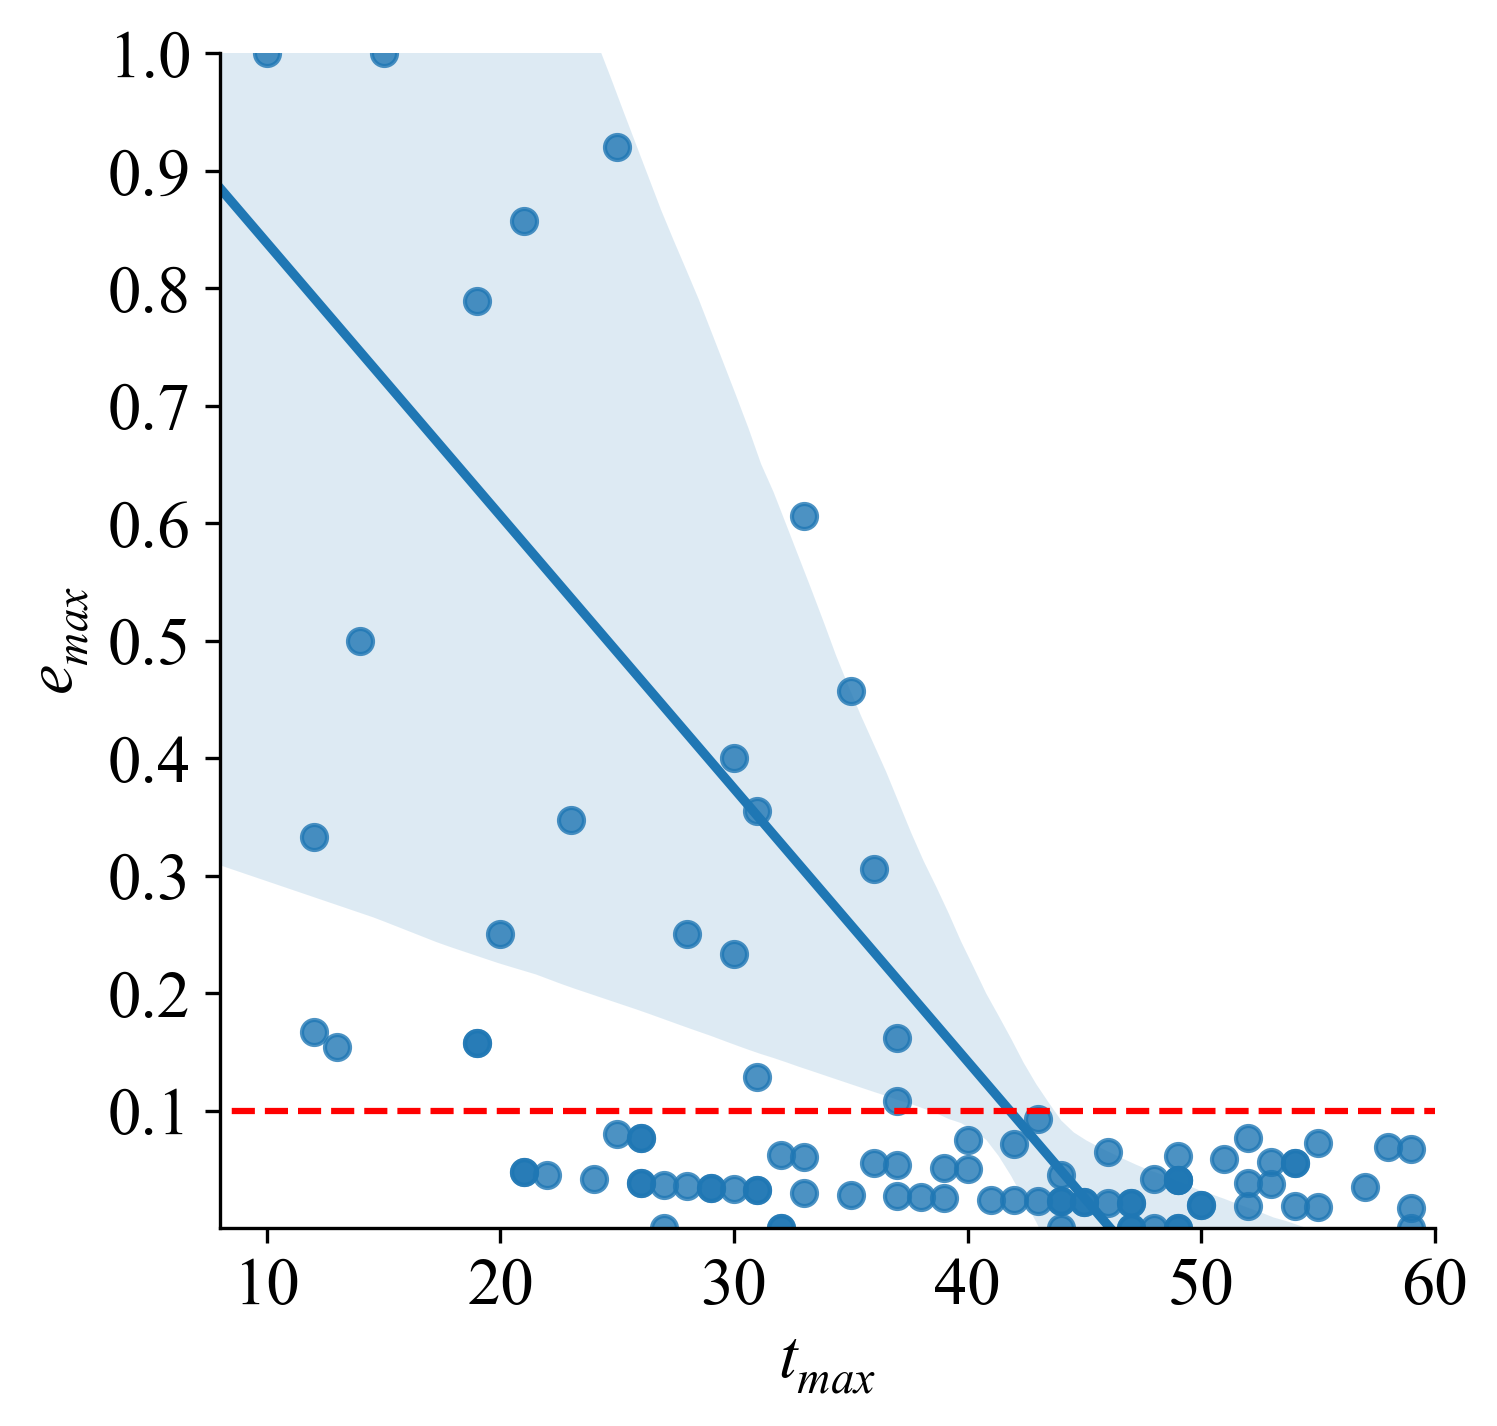

In [17]:
import seaborn as sns
import matplotlib.ticker as ticker

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8,6)
plt.rc('font',family='Times New Roman')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

g = sns.lmplot(x="real_balance_t", y="t_ratio", data=df)

g.set(xlim=(8,60))
g.set(ylim=(0, 1))
g.set_axis_labels(r'$\it{t_{max}}$',r'$\it{e_{max}}$') 
g.ax.plot([0, 60], [0.1, 0.1], c='r', linestyle='--')

ax = g.axes[0, 0]  # 假设只有一个子图

formatter = ticker.FuncFormatter(lambda x, pos: '' if x == 0 else f'{x:.1f}')
ax.yaxis.set_major_formatter(formatter)
# 移动x轴的脊梁到y轴的脊梁位置

ax.set_yticks([ 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

ax.spines['bottom'].set_position(('data', 0))  # 指定 data 设置的bottom(也就是指定的x轴)绑定到y轴的0这个点上
ax.spines['left'].set_position(('data', 8))

savefile = './pic/'
figname = 'balance-t-ratio1'

plt.savefig(savefile+figname)

plt.show()

In [29]:
balance_frequency = [0 for i in range(10)]
range_boundary = np.linspace(0,0.5,11,retstep = False)
print(range_boundary)

for i in df['t_ratio']:
    if range_boundary[0] < i <= range_boundary[1]:
        balance_frequency[0] += 1
    elif range_boundary[1] < i <= range_boundary[2]:
        balance_frequency[1] += 1
    elif range_boundary[2] < i <= range_boundary[3]:
        balance_frequency[2] += 1
    elif range_boundary[3] < i <= range_boundary[4]:
        balance_frequency[3] += 1
    elif range_boundary[4] < i <= range_boundary[5]:
        balance_frequency[4] += 1
    elif range_boundary[5] < i <= range_boundary[6]:
        balance_frequency[5] += 1
    elif range_boundary[6] < i <= range_boundary[7]:
        balance_frequency[6] += 1
    elif range_boundary[7] < i <= range_boundary[8]:
        balance_frequency[7] += 1
    elif range_boundary[8] < i <= range_boundary[9]:
        balance_frequency[8] += 1
    elif range_boundary[9] < i <= range_boundary[10]:
        balance_frequency[9] += 1
balance_frequency

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


[43, 21, 2, 5, 3, 0, 3, 2, 0, 2]